## Homework 3

## <em> Linear Algebra - Gaussian Elimination, SVD, Polynomial Regression, PCA, KNN, and Data Modeling</em>
<br>
This notebook is arranged in cells. Texts are usually written in the markdown cells, and here you can use html tags (make it bold, italic, colored, etc). You can double click on this cell to see the formatting.<br>
<br>
The ellipsis (...) are provided where you are expected to write your solution but feel free to change the template (not over much) in case this style is not to your taste. <br>
<br>
<em>Hit "Shift-Enter" on a code cell to evaluate it.  Double click a Markdown cell to edit. </em><br>

***

### Imports

In [1]:
import numpy as np
from scipy.integrate import quad
import sklearn as sk
from sklearn import datasets, linear_model
from sklearn.preprocessing import PolynomialFeatures
#For plotting
import matplotlib.pyplot as plt
%matplotlib inline

### Mounting Google Drive locally
Mount your Google Drive on your runtime using an authorization code.

Note: When using the 'Mount Drive' button in the file browser, no authentication codes are necessary for notebooks that have only been edited by the current user.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

***

#### Problem 1 - Solving Least Squares Using Normal Equations and SVD

(Reference - NR 15.4) We fit a set of 50 data points $(x_i, y_i)$ to a polynomial $y(x) = a_0 + a_1x + a_2x^2 + a_3x^3$. (Note that this problem is linear in $a_i$ but nonlinear in $x_i$). The uncertainty $\sigma_i$ associated with each measurement $y_i$ is known, and we assume that the $x_i$'s are known exactly. To measure how well the model agrees with the data, we use the chi-square merit function: <br>
$$ \chi^2 = \sum_{i=0}^{N-1} \big( \frac{y_i-\sum_{k=0}^{M-1}a_k x^k}{\sigma_i} \big)^2. $$
<br>
where N = 50 and M = 4. Here, $1, x, ... , x^3$ are the basis functions.
<br><br>
<span style="color:blue"> <i> 1. Plot data. (Hint - https://matplotlib.org/api/_as_gen/matplotlib.axes.Axes.errorbar.html) </i></span><br>



<span style="color:red"> Again, in this and all future assignments, you are expected to show error bars in all figures if the data include uncertainties. You will lose points if error bars are not shown. </span>

In [126]:
# Load a given 2D data
# data = np.loadtxt("Problem1_data.dat")
data = np.loadtxt("/Users/elizabeth/Library/CloudStorage/GoogleDrive-elizabeth.donoway@gmail.com/.shortcut-targets-by-id/1N7VNzEhLpxeYFHjRpWdzVH2k_ZEUEjV6/P188_288/P188_288_HW3/Problem1_data.dat")
x = data[:,0]
y = data[:,1]
sig_y = data[:,2]

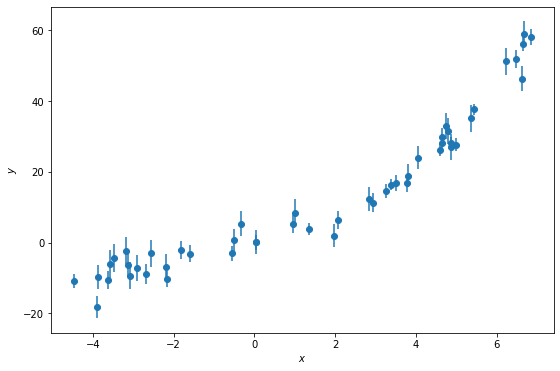

In [127]:
plt.figure(figsize=(9,6))
plt.errorbar(x, y, yerr=sig_y, marker='o', linestyle='')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.show()

We will pick as best parameters those that minimize $\chi^2$.<br><br>
First, let $\bf A$ be a matrix whose $N \times M$ components are constructed from the $M$ basis functions evaluated at the $N$ abscissas $x_i$, and from the $N$ measurement errors $\sigma_i$, by the prescription
$$ A_{ij} = \frac{X_j(x_i)}{\sigma_i} $$
<br>where $X_0(x) = 1,\ X_1(x) = x,\ X_2(x) = x^2,\ X_3(x) = x^3$. We call this matrix $\bf A$ the design matrix.
<br><br>
Also, define a vector $\bf b$ of length $N$ by
$$ b_i = \frac{y_i}{\sigma_i} $$
<br>and denote the $M$ vector whose components are the parameters to be fitted ($a_0, a_1, a_2, a_3$) by $\bf a$.
<br><br>
<span style="color:blue"><i> 2. Define the design matrix A. (Hint: Its dimension should be NxM = 50x4.) Also, define the vector b. Print the first row of A. </i></span><br>


In [128]:
A = np.array([[1, x[i], x[i]**2, x[i]**3]/sig_y[i] for i in range(len(x))])
b = y/sig_y
print('First row of A:', A[0])

First row of A: [0.30368985 0.60162612 1.1918541  2.36112786]


Minimize $\chi^2$ by differentiating it with respect to all $M$ parameters $a_k$ vaishes. This condition yields the matrix equation <br>
$$ \sum_{j=0}^{M-1} \alpha_{kj}a_j = \beta_k$$ 
<br> where $\bf \boldsymbol \alpha = A^T \cdot A$ and $\bf \boldsymbol \beta = A^T \cdot b$ ($\boldsymbol \alpha$ is an $M \times M$ matrix, and $\boldsymbol \beta$ is a vector of length $M$). This is the normal equation of the least squares problem. In matrix form, the normal equations can be written as:
$$ \bf \boldsymbol \alpha \cdot a = \boldsymbol \beta. $$
<br><br>
This can be solved for the vector of parameters $\bf a$ by linear algebra numerical methods.
<br><br>
<span style="color:blue"> <i> 3. Define the matrix alpha and vector beta. Print both alpha and beta. </i></span><br>

In [129]:
alpha = np.dot(A.T, A)
beta = np.dot(A.T, b)
print('Alpha:', alpha)
print('Beta:', beta)

Alpha: [[7.57344292e+00 1.59581405e+01 1.20838371e+02 4.80208969e+02]
 [1.59581405e+01 1.20838371e+02 4.80208969e+02 3.20704253e+03]
 [1.20838371e+02 4.80208969e+02 3.20704253e+03 1.62887892e+04]
 [4.80208969e+02 3.20704253e+03 1.62887892e+04 1.05149671e+05]]
Beta: [  118.53904396   727.88040211  3581.30337095 22023.93157276]


<span style="color:blue"> <i> 4. We have $ \bf \boldsymbol \alpha \cdot a = \boldsymbol \beta. $ Solve for $\bf a$ using (1) GaussianElimination_pivot with pivoting (See undergrad version for hints) (2) LU decomposition and forward subsitution and backsubstitution. (https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.linalg.lu_factor.html
) Plot the best-fit line on top of the data. </i></span><br>


Hint: You can use scipy.linalg.lu to do the LU decomposition. After you do "L, U = lu(A, permute_l=True)," print L and U matrices. Note that L is not a lower triangle matrix. Swap rows of L (and B) and make it a lower triangular matrix. And then, solve for y in Ly = B.

e.g.
If your L matrix is the following:

[[ 0.01577114 0.10593754 0.41569921 1. ]
[ 0.03323166 -0.04364428 1. 0. ]
[ 0.25163705 1. 0. 0. ]
[ 1. 0. 0. 0. ]],

you can change it to this:

[[ 1. 0. 0. 0. ]
[ 0.25163705 1. 0. 0. ]
[ 0.03323166 -0.04364428 1. 0. ]
[ 0.01577114 0.10593754 0.41569921 1. ]]

Then, you should also change B from

[ 118.53904396 727.88040211 3581.30337095 22023.93157276]

to

[22023.93157276 3581.30337095 727.88040211 118.53904396].

In [130]:
# Using the Gaussian elimination with partial pivoting
def GE_pivot(A, b):
    # Check if the dimensions of A and b are compatible
    if A.shape[0] != b.shape[0]:
        raise ValueError("The number of rows in A must match the length of b.")

    # Make b last column of new matrix to do GE on
    augmented_matrix = np.hstack((A, b.reshape(-1, 1)))

    num_rows, num_cols = augmented_matrix.shape

    for row in range(num_rows):
        # Find the pivot row (row with the largest absolute value in the current column)
        pivot_row = max(range(row, num_rows), key=lambda i: abs(augmented_matrix[i, row]))

        # Swap the current row with the pivot row
        augmented_matrix[[row, pivot_row]] = augmented_matrix[[pivot_row, row]]

        # Normalize the pivot row
        pivot_element = augmented_matrix[row, row]
#         print(augmented_matrix[row], pivot_element)
        augmented_matrix[row] /= pivot_element

        # Eliminate all entries below the pivot element
        for i in range(row + 1, num_rows):
            factor = augmented_matrix[i, row]
            augmented_matrix[i] -= factor * augmented_matrix[row]

#     print(augmented_matrix)
    
    # Back-substitution to solve for x
    x = np.zeros(num_cols - 1)
    for i in range(num_rows - 1, -1, -1):
        x[i] = augmented_matrix[i, -1]
        for j in range(i + 1, num_rows):
            x[i] -= augmented_matrix[i, j] * x[j]

    return x

a = GE_pivot(alpha, beta)
print('Using Gaussian Elimination:')
print('a0 =', a[0], ', a1 =', a[1], ', a2 =', a[2], ', a3 =', a[3])

Using Gaussian Elimination:
a0 = -0.03081629537271624 , a1 = 2.6676460822498766 , a2 = 0.3148392700785271 , a3 = 0.07945935335134537


In [320]:
q1A = np.array([[1,1,-2,-1], [1,5,-3,-2], [3,-1,1,4], [-2,2,1,0]], dtype=float)
q1b = np.array([-1,0,2,2], dtype=float)
q1a = GE_pivot(q1A,q1b)
print(q1a)

[-0.5  0.5  0.   1. ]


In [292]:
# "lu" does LU decomposition with pivot. Reference - https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.linalg.lu_factor.html
from scipy.linalg import lu

def LU_pivot(A, b):
    # LU decomposition with pivot
    L, U = lu(A, permute_l=True)
#     print(L)
#     print(U)
    
    # Make L lower triangular and swap values of b accordingly
    L_rev = L[::-1] # np.array([L[-i] for i in range(1,len(L)+1)])
    b_rev = b[::-1] # np.array([b[-i] for i in range(1,len(b)+1)])
    
    # Forward substitution: Solve Ly = b for y
    y = np.linalg.inv(L_rev) @ b_rev
#     y = np.linalg.solve(L, b)

    # Backward substitution: Solve y = Ux
    x = np.dot(np.linalg.inv(U), y)
#     x = np.linalg.solve(U, y)
    
    return x

a = LU_pivot(alpha, beta)

print('Using LU Decomposition:')
print('a0 =', a[0], ', a1 =', a[1], ', a2 =', a[2], ', a3 =', a[3])

Using LU Decomposition:
a0 = -0.03081629537270203 , a1 = 2.667646082249883 , a2 = 0.3148392700785254 , a3 = 0.07945935335134535


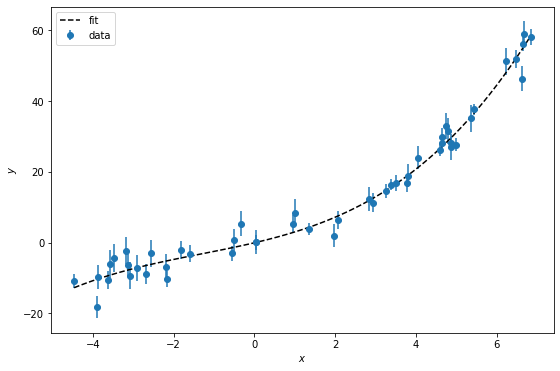

In [132]:
def poly_fit(x, a):
    poly = np.array([a[i] * x**i for i in range(len(a))])
    return np.sum(poly, axis=0)

xfit = np.linspace(np.min(x), np.max(x), 100)

plt.figure(figsize=(9,6))
plt.errorbar(x, y, yerr=sig_y, marker='o', linestyle='', label='data')
plt.plot(xfit, poly_fit(xfit, a), linestyle='--', color='k', label='fit')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.legend()
plt.show()

The inverse matrix $\bf C = \boldsymbol \alpha^{-1}$ is called the covariance matrix, which is closely related to the probable uncertainties of the estimated parameters $\bf a$. To estimate these uncertainties, we compute the variance associated with the estimate $a_j$. Following NR p.790, we obtain: <br><br>
$$ \sigma^2(a_j) = \sum_{k=0}^{M-1} \sum_{l=0}^{M-1} C_{jk} C_{jl} \alpha_{kl} = C_{jj}$$
<br>
<span style="color:blue"> <i> 5. Compute the error (standard deviation - square root of the variance) on the fitted parameters using the covariance matrix. </i></span><br>

In [133]:
from scipy.linalg import inv
# Covariance matrix

C = inv(alpha)
sig_a = np.sqrt([C[i,i] for i in range(len(C))])
print('Error: on a0 = %0.9f , on a1 = %0.9f , on a2 = %0.9f , on a3 = %0.9f' % tuple(sig_a))
# print('Error: on a0 =', sig_a[0], ', on a1 =', sig_a[1], ', on a2 =', sig_a[2], ', on a3 =', sig_a[3])

Error: on a0 = 0.713941893 , on a1 = 0.223902740 , on a2 = 0.063448143 , on a3 = 0.011998697


Now, instead of using the normal equations, we use singular value decomposition (SVD) to find the solution of least squares. Please read Ch. 15 of NR for more details. Remember that we have the $N \times M$ design matrix $\bf A$ and the vector $\bf b$ of length $N$. We wish to mind $\bf a$ which minimizes $\chi^2 = |\bf A \cdot a - b|^2$.
<br><br>
Using SVD, we can decompose $\bf A$ as the product of an $N \times M$ column-orthogonal matrix $\bf U$, an $M \times M$ diagonal matrix $\bf S$ (with positive or zero elements - the "singular" values), and the transpose of an $M \times M$ orthogonal matrix $\bf V$. ($\bf A = USV^{T}$). <br>
Let $\bf U_{(i)}$ and $\bf V_{(i)}$ denote the columns of $\bf U$ and $\bf V$ respectively (Note: We get $M$ number of vectors of length $M$.) $\bf S_{(i,i)}$ are the $i$th diagonal elements (singular values) of $\bf S$. Then, the solution of the above least squares problem can be written as:
<br>
$$ \bf a = \sum_{i=1}^M \big( \frac{U_{(i)} \cdot b}{S_{(i,i)}} \big) V_{(i)}. $$
<br><br>
The variance in the estimate of a parameter $a_j$ is given by:
$$ \sigma^2(a_j) = \sum_{i=1}^M \big( \frac{V_{ji}}{S_{ii}} \big)^2 $$
<br>
and the covariance:
$$ \mathrm{Cov}(a_j, a_k) = \sum_{i=1}^M \big( \frac{V_{ji}V_{ki}}{S_{ii}^2} \big). $$
<br><br>
<span style="color:blue"> <i> 6. Decompose the design matrix A using SVD. Estimate the parameter $a_i$'s and its variance. </i></span><br>

Minimizing $\chi^2$ loss is equivalent to finding solution closest to $\mathbf{A}\cdot\mathbf{a} = \mathbf{b}$, which amounts to finding projection of $\mathbf{b}$ on column space of $\mathbf{A}$ (finding projection of solution/label vector $\mathbf{b}$ weighted by error onto design matrix $\mathbf{A}$).

In [139]:
# Reference - https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.linalg.svd.html
from scipy.linalg import svd

# def solve_svd2(A, b):
#     U, S, VT = svd(A)
#     V = VT.T
# #     print(np.shape(VT.T), np.shape(S), np.shape(U), np.shape(b))
    
#     frac = [np.dot(U[:,i], b)/S[i] for i in range(len(S))]
#     a = [np.dot(frac, V[:,i]) for i in range(len(S))]
#     return a

def solve_svd(A, b):
    # Perform SVD decomposition
    U, S, VT = svd(A, full_matrices=False)
    V = VT.T

    # Pseudo-inverse of S (replace small singular values with zeros)
    S_inv = np.diag(np.where(S > 1e-10, 1 / S, 0))
    
    # Solve for x using SVD
    x = V @ S_inv @ U.T @ b

    return x

# print(solve_svd2(A, b))
# print(solve_svd(A, b))

a_from_SVD = solve_svd(A, b)

print('Using SVD:')
print('a0 =', a_from_SVD[0], ', a1 =', a_from_SVD[1], ', a2 =', a_from_SVD[2], ', a3 =', a_from_SVD[3])

# Error on a
def var_SVD2(A, b):
    U, S, VT = svd(A)
    V = VT.T
    
    return np.sum([(VT[i]/S[i])**2 for i in range(len(S))], axis=0) # axis=0 b/c sum over rows of VT_ij = columns of V_ji
#     return np.sum([(V[:,i]/S[i])**2 for i in range(len(S))], axis=0)

def var_SVD(A, b):
    U, S, VT = svd(A, full_matrices=False)
    V = VT.T
    
    S_inv = np.diag(np.where(S > 1e-10, 1 / S, 0))
    
#     print((VT @ S_inv)**2)
#     print(VT @ S_inv)
    return np.sum((VT @ S_inv)**2, axis=1) # should this be axis=1 or axis=0? I think 1 so we sum over columns?

sigma_a_SVD = np.sqrt(var_SVD(A, b))

print('Error: on a0 =', sigma_a_SVD[0], ', on a1 =', sigma_a_SVD[1], ', on a2 =', sigma_a_SVD[2], ', on a3 =', sigma_a_SVD[3])

Using SVD:
a0 = -0.03081629537274068 , a1 = 2.6676460822498833 , a2 = 0.3148392700785281 , a3 = 0.07945935335134492
Error: on a0 = 0.7120836334398011 , on a1 = 0.2336600158313593 , on a2 = 0.04536536296761227 , on a3 = 0.017233068495053478


Suppose that you are only interested in the parameters $a_0$ and $a_1$. We can plot the 2-dimensional confidence region ellipse for these parameters by building the covariance matrix:
$$ \mathrm{C'} =  \binom{\sigma({a_0})^2\ \ \ \ \ \ \mathrm{Cov}({a_0, a_1})}{\mathrm{Cov}({a_0, a_1}) \ \ \ \ \ \ \sigma({a_1})^2} $$
<br><br>
The lengths of the ellipse axes are the square root of the eigenvalues of the covariance matrix, and we can calculate the counter-clockwise rotation of the ellipse with the rotation angle:
$$ \theta = \frac{1}{2} \mathrm{arctan}\Big( \frac{2\cdot \mathrm{Cov}({a_0, a_1})}{\sigma({a_0})^2-\sigma({a_1})^2} \Big) = \mathrm{arctan}(\frac{\vec{v_1}(y)}{\vec{v_1}(x)}) $$
<br>
where $\vec{v_1}$ is the eigenvector with the largest eigenvalue. So we calculate the angle of the largest eigenvector towards the x-axis to obtain the orientation of the ellipse. <br><br> 
<br>
Then, we multiply the axis lengths by some factor depending on the confidence level we are interested in. For 68%, this scale factor is $\sqrt{\Delta \chi^2} \approx 1.52$. For 95%, it is $\approx 2.48$.
<br><br>
<span style="color:blue"> <i> 7. Compute the covariance between $a_0$ and $a_1$. Plot the 68% and 95% confidence region of the parameter $a_0$ and $a_1$. </i></span><br>

In [149]:
from matplotlib.patches import Ellipse
import matplotlib as mpl
from numpy.linalg import eigvals

In [146]:
# Build the covariance matrix
def cov_SVD(A, b):
    U, S, VT = svd(A)
    V = VT.T

    return np.sum([(np.outer(VT[i],VT[i])/S[i]**2) for i in range(len(S))], axis=0)
#     return np.sum([(np.outer(V[:,i],V[:,i])/S[i]**2) for i in range(len(S))], axis=0) # why not V.T x V?
    
CovM = cov_SVD(A, b)[:2,:2]

print('Covariance between a0 and a1:', CovM[0,1])

Covariance between a0 and a1: -0.05496242872796253


In [147]:
CovM

array([[ 0.50971303, -0.05496243],
       [-0.05496243,  0.05013244]])

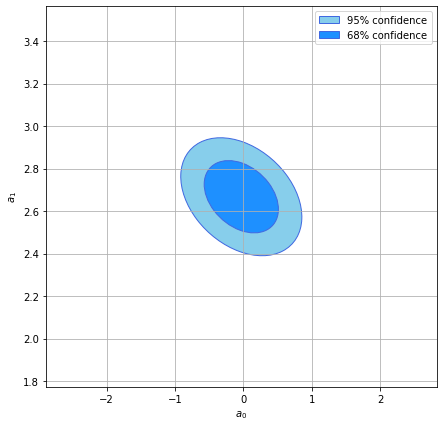

In [152]:
# Plot the confidence region (https://stackoverflow.com/questions/32371996/python-matplotlib-how-to-plot-ellipse)

eigvec, eigval, u = np.linalg.svd(CovM)

# Semimajor axis (diameter)
semimaj = np.max(np.sqrt(eigval))
# Semiminor axis (diameter)
semimin = np.min(np.sqrt(eigval))

theta = np.arctan(eigvec[1,np.argmax(eigval)]/eigvec[0,np.argmax(eigval)])
   
# Plot 1-sig confidence region
ell = mpl.patches.Ellipse(xy=[a[0], a[1]], width=1.52*semimaj, height=1.52*semimin, angle = theta*180/np.pi, facecolor = 'dodgerblue', edgecolor = 'royalblue', label = '68% confidence')
# Plot 2-sig confidence region
ell2 = mpl.patches.Ellipse(xy=[a[0], a[1]], width=2.48*semimaj, height=2.48*semimin, angle = theta*180/np.pi, facecolor = 'skyblue', edgecolor = 'royalblue', label = '95% confidence')

fig, ax = plt.subplots(figsize=(7,7))

ax.add_patch(ell2)
ax.add_patch(ell)


# Set bounds for x,y axes
bounds = np.sqrt(CovM.diagonal())
plt.xlim(a[0]-4*bounds[0], a[0]+4*bounds[0])
plt.ylim(a[1]-4*bounds[1], a[1]+4*bounds[1])

plt.grid(True)
plt.xlabel('$a_0$')
plt.ylabel('$a_1$')
plt.legend()
plt.show()

In lecture, we discussed that we fit the existing data to obtain model parameters in data analysis, while in machine learning we use the model derived from the existing data to make prediction for new data.

Next, let us take the given data and do the polynomial regression.

First, split the sample into training data and the testing data. Keep 80% data as training data and uses the remaining 20% data for testing. 

<span style="color:blue"> <i> 8. Often, the data can be ordered in a specific manner, hence shuffle the data prior to splitting it into training and testing samples. (Use https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.shuffle.html) </i></span><br>

In [157]:
combined_data = np.column_stack((x, y, sig_y))
np.random.shuffle(combined_data)
x_shuff = combined_data[:, 0]
y_shuff = combined_data[:, 1]
sig_y_shuff = combined_data[:, 2]

x_train = x_shuff[:int(len(y)*0.8)]
y_train = y_shuff[:int(len(y)*0.8)]
sig_y_train = sig_y_shuff[:int(len(y)*0.8)]

x_test = x_shuff[:int(len(y)*0.2)]
y_test = y_shuff[:int(len(y)*0.2)]
sig_y_test = sig_y_shuff[:int(len(y)*0.2)]

In the case of polynomial regression, we need to generate polynomial features (http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html) for preprocessing. Note that we call each term in the polynomial as a "feature" in our model, and here we generate features' high-order (and interaction) terms. For example, suppose we set the degree of the polynomial to be 3. Then, the features of $X$ is transformed from $(X)$ to $(1, X, X^2, X^3)$. We can do this transform using PolynomialFeatures.fit_transform(train_x). But fit_transform() takes the numpy array of shape [n_samples, n_features]. So you need to re-define our training set as train_set_prep = train_x[:,np.newaxis] so that it has the shape [40,1].

<span style="color:blue"> <i> 9. Define three different polynomial models with degree of 1, 3, 10. (e.g. model = PolynomialFeatures(degree=...) ) Then, fit to data and transform it using "fit_transform"  </i></span><br>

In [160]:
train_set_prep = x_train[:,np.newaxis]

In [165]:
from sklearn.preprocessing import PolynomialFeatures
# e.g.
# model = PolynomialFeatures(degree = ...)
# X_model = model.fit_transform(train_x[:,np.newaxis])

model1 = PolynomialFeatures(degree=1)
deg1_train = model1.fit_transform(x_train[:,np.newaxis])
# deg1_test = model1.transform(x_test[:,np.newaxis])

model3 = PolynomialFeatures(degree=3)
deg3_train = model3.fit_transform(x_train[:,np.newaxis])
# deg3_test = model3.transform(x_test[:,np.newaxis])

model10 = PolynomialFeatures(degree=10)
deg10_train = model10.fit_transform(x_train[:,np.newaxis])
# deg10_test = model10.transform(x_test[:,np.newaxis])

Then, do the least squares linear regression. (http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html#sklearn.linear_model.LinearRegression.fit) 

1. define the object for linear regression: LR = linear_model.LinearRegression()
2. Fit the linear model to the training data: LR.fit(transformed x data, y data)
3. Define new x samples for plotting: X_sample = np.linspace(-5, 7, 100)
4. Transform x sample: X_sample_transform = model.fit_transform(X_sample[:,np.newaxis])
4. Predict using the linear model: Y_sample = LR.predict(X_sample_transform)
5. Plot the fit: plt.plot(X_sample, Y_sample)


<span style="color:blue"> <i> 10. Do the linear regression for three different polynomial models defined in Part 9. Plot the fit on top of the training data (Label each curve). </i></span><br>

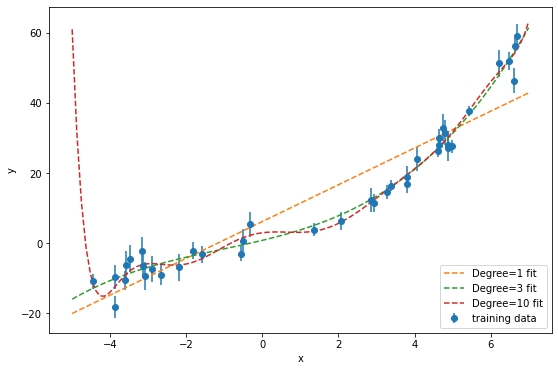

In [296]:
from sklearn.linear_model import LinearRegression

LR = LinearRegression()
LR.fit(deg1_train, y_train)
X_sample = np.linspace(-5, 7, 100)
X1_sample_transform = model1.fit_transform(X_sample[:,np.newaxis])
Y1_sample = LR.predict(X1_sample_transform)

# plt.errorbar(x_train, y_train, yerr=sig_y_train, marker='o', linestyle='', label='training data')
# plt.plot(X_sample, Y_sample, linestyle='--', color='k', label='fit')
# plt.legend()
# plt.xlabel('x')
# plt.ylabel('y')
# plt.title('Degree = 1')
# plt.show()

LR = LinearRegression()
LR.fit(deg3_train, y_train)
X_sample = np.linspace(-5, 7, 100)
X3_sample_transform = model3.fit_transform(X_sample[:,np.newaxis])
Y3_sample = LR.predict(X3_sample_transform)

# plt.errorbar(x_train, y_train, yerr=sig_y_train, marker='o', linestyle='', label='training data')
# plt.plot(X_sample, Y_sample, linestyle='--', color='k', label='fit')
# plt.legend()
# plt.xlabel('x')
# plt.ylabel('y')
# plt.title('Degree = 3')
# plt.show()

LR = LinearRegression()
LR.fit(deg10_train, y_train)
X_sample = np.linspace(-5, 7, 100)
X10_sample_transform = model10.fit_transform(X_sample[:,np.newaxis])
Y10_sample = LR.predict(X10_sample_transform)

plt.figure(figsize=(9,6))
plt.errorbar(x_train, y_train, yerr=sig_y_train, marker='o', linestyle='', label='training data')
plt.plot(X_sample, Y1_sample, linestyle='--', label='Degree=1 fit')
plt.plot(X_sample, Y3_sample, linestyle='--', label='Degree=3 fit')
plt.plot(X_sample, Y10_sample, linestyle='--', label='Degree=10 fit')
plt.legend()
plt.xlabel('x')
plt.ylabel('y')
# plt.title('Degree = 3')
plt.show()


<span style="color:blue"> <i> 11. Plot the fit on top of the test data (Label each curve). </i></span><br>

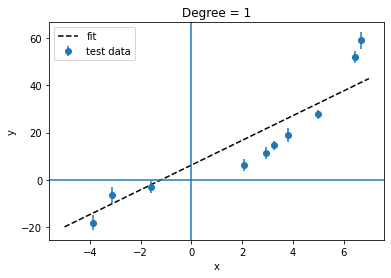

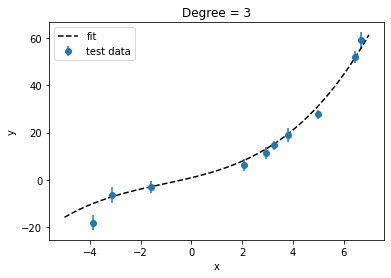

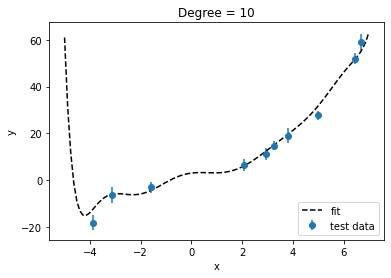

In [305]:
from sklearn.linear_model import LinearRegression

LR1 = LinearRegression()
LR1.fit(deg1_train, y_train)
X_sample = np.linspace(-5, 7, 100)
X_sample_transform = model1.fit_transform(X_sample[:,np.newaxis])
Y_sample = LR1.predict(X_sample_transform)

plt.errorbar(x_test, y_test, yerr=sig_y_test, marker='o', linestyle='', label='test data')
plt.plot(X_sample, Y_sample, linestyle='--', color='k', label='fit')
plt.axvline(0)
plt.axhline(0)
plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.title('Degree = 1')
plt.show()

LR3 = LinearRegression()
LR3.fit(deg3_train, y_train)
X_sample = np.linspace(-5, 7, 100)
X_sample_transform = model3.fit_transform(X_sample[:,np.newaxis])
Y_sample = LR3.predict(X_sample_transform)

plt.errorbar(x_test, y_test, yerr=sig_y_test, marker='o', linestyle='', label='test data')
plt.plot(X_sample, Y_sample, linestyle='--', color='k', label='fit')
plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.title('Degree = 3')
plt.show()

LR10 = LinearRegression()
LR10.fit(deg10_train, y_train)
X_sample = np.linspace(-5, 7, 100)
X_sample_transform = model10.fit_transform(X_sample[:,np.newaxis])
Y_sample = LR10.predict(X_sample_transform)

plt.errorbar(x_test, y_test, yerr=sig_y_test, marker='o', linestyle='', label='test data')
plt.plot(X_sample, Y_sample, linestyle='--', color='k', label='fit')
plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.title('Degree = 10')
plt.show()

You can obtain the estimated linear coefficients using linear_model.LinearRegression.coef_ (http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html#sklearn.linear_model.LinearRegression)


<span style="color:blue"> <i> 12. Print the linear coefficients of three polynomial models you used. For the polynomial of degree 10, do you see that high-order coefficients are very small? </i></span><br>

In [317]:
print('Degree 1 coefficients:', LR1.coef_, LR1.intercept_)
print('Degree 3 coefficients:', LR3.coef_, LR3.intercept_)
print('Degree 10 coefficients:', LR10.coef_, LR10.intercept_)

Degree 1 coefficients: [0.         5.23856791] 6.2016882722332145
Degree 3 coefficients: [0.         2.61512207 0.27295125 0.08424735] 0.8519444689284743
Degree 10 coefficients: [ 0.00000000e+00  1.37775114e+00 -2.41610100e+00  7.89232243e-01
  5.34734525e-01 -1.40864796e-01 -3.27352187e-02  1.06513379e-02
  2.68788520e-04 -2.62192002e-04  1.80269894e-05] 3.0033178130377323


***

#### Problem 2 - Applying the PCA Method on Quasar Spectra

The following analysis is based on https://arxiv.org/pdf/1208.4122.pdf.
<br><br>
"Principal Component Analysis (PCA) is a powerful
and widely used technique to analyze data
by forming a custom set of “principal component”
eigenvectors that are optimized to describe the
most data variance with the fewest number of
components. With the full set of eigenvectors the data
may be reproduced exactly, i.e., PCA is a transformation
which can lend insight by identifying
which variations in a complex dataset are most
significant and how they are correlated. Alternately,
since the eigenvectors are optimized and
sorted by their ability to describe variance in the
data, PCA may be used to simplify a complex
dataset into a few eigenvectors plus coefficients,
under the approximation that higher-order eigenvectors
are predominantly describing fine tuned
noise or otherwise less important features of the
data." (S. Bailey, arxiv: 1208.4122)
<br><br>
In this problem, we take the quasar (QSO) spectra from the Sloan Digital Sky Survey (SDSS) and apply PCA to them. Filtering for high $S/N$ in order to apply the standard PCA, we select 18 high-$S/N$ spectra of QSOs with redshift 2.0 < z < 2.1, trimmed to $1340 < \lambda < 1620\ \mathring{A}$.

In [2]:
# Load data
# wavelength = np.loadtxt("/content/drive/My Drive/P188_288/P188_288_HW3/Problem2_wavelength.txt")
# flux = np.loadtxt("/content/drive/My Drive/P188_288/P188_288_HW3/Problem2_QSOspectra.txt")
folderpath = '/Users/elizabeth/Library/CloudStorage/GoogleDrive-elizabeth.donoway@gmail.com/.shortcut-targets-by-id/1N7VNzEhLpxeYFHjRpWdzVH2k_ZEUEjV6/P188_288/P188_288_HW3//'
wavelength = np.loadtxt(folderpath+"Problem2_wavelength.txt")
flux = np.loadtxt(folderpath+"Problem2_QSOspectra.txt")

In [3]:
# Data dimension
print( np.shape(wavelength) )
print( np.shape(flux) )

(824,)
(18, 824)


In the above cell, we load the following data: wavelength in Angstroms ("wavelength") and 2D array of spectra x fluxes ("flux").
<br><br>
We have 824 wavelength bins, so "flux" is 18 $\times$ 824 matrix, each row containing fluxes of different QSO spectra.
<br><br>
<span style="color:blue"> <i> 1. Plot any three QSO spectra flux as a function of wavelength. (In order to better see the features of QSO spectra, you may plot them with some offsets.) </i></span> <br>

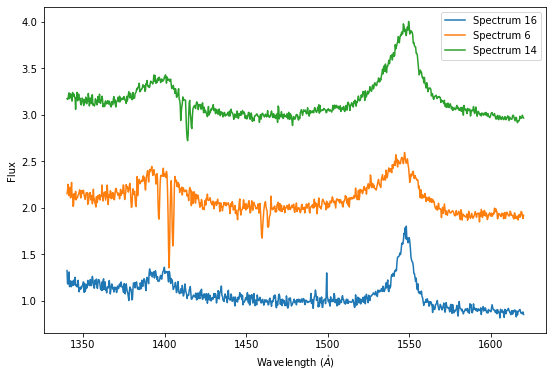

In [294]:
plt.figure(figsize=(9,6))
for offset in range(3):
    spec_num = np.random.randint(0,17)
    plt.plot(wavelength, offset+flux[spec_num], marker='', linestyle='-', label=f'Spectrum {spec_num}')
plt.xlabel('Wavelength ($\mathring{A}$)')
plt.ylabel('Flux')
plt.legend()
plt.show()

"Flux" is the data matrix of order 18 $\times$ 824. Call this matrix $\bf X$. 
<br><br>
We can construct the covariance matrix $\bf C$ using the mean-centered data matrix. First, calculate the mean of each column and subtracts this from the column. Let $\bf X_c$ denote the mean-centered data matrix.<br><br>
$\bf X_c$ $ =
    \begin{bmatrix}
        x_{(1,1)} - \overline{x}_1 & x_{(1,2)} - \overline{x}_2 & \dots  & x_{(1,824)} - \overline{x}_{824} \\
        x_{(2,1)} - \overline{x}_1 & x_{(2,2)} - \overline{x}_2 & \dots  & x_{(2,824)} - \overline{x}_{824} \\
        \vdots & \vdots & \vdots & \vdots \\
        x_{(18,1)} - \overline{x}_1 & x_{(18,2)} - \overline{x}_2 & \dots  & x_{(18,824)} - \overline{x}_{824}
    \end{bmatrix}$
<br><br>
where $x_{m,n}$ denote the flux of $m$th QSO in $n$th wavelength bin, and $\overline{x}_k$ is the mean flux in $k$th wavelength bin.
<br><br>
Then, the covariance matrix is:
$\bf C$ $ = \frac{1}{N-1}$ $\bf X_c^T X_c.$ ($N$ is the number of QSOs.)
<br><br>
<span style="color:blue"><i> 2. Find the covariance matrix C using the data matrix flux. </i></span><br>


In [216]:
meanflux = np.mean(flux, axis=0)
X = flux
X_c = X - meanflux
N = len(flux)
C = 1/(N-1) * X_c.T @ X_c

<span style="color:blue"> <i> 3. Using numpy.linalg, find eigenvalues and eigenvectors of the covariance matrix. Order the eigenvalues from largest to smallest and then plot them as a function of the number of eigenvalues. (Remember that the eigenvector with the highest eigenvalue is the principle component of the data set.)
In this case, we find that our covariance matrix is rank-17 matrix, so we only select the first 17 highest eigenvalues and corresponding eigenvectors (other eigenvalues are close to zero). </i></span><br>

Here, by ranking the eigenvalues based on their magnitudes, you basically rank them in order of significance. You should show that the first few components are dominant, accounting for most of the variability in the data. So you can plot eigenvalues as a function of component number (1,2,3,...,17)

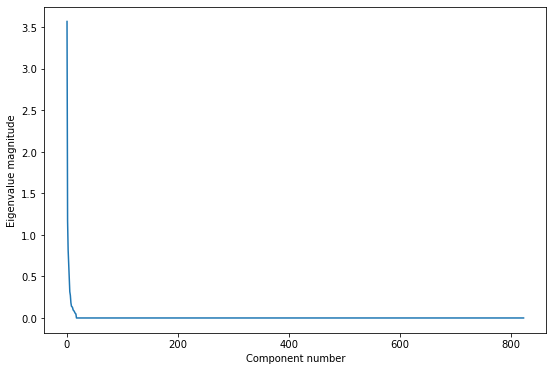

In [217]:
from numpy.linalg import eig

eigvals, eigvecs = eig(C)

magevals = np.abs(eigvals)
evals_sorted = np.sort(magevals)[::-1]

plt.figure(figsize=(9,6))
plt.plot(np.arange(0,len(wavelength),1), evals_sorted)
plt.xlabel('Component number')
plt.ylabel('Eigenvalue magnitude')
plt.show()
# After eigenvalue 17, the magnitude of the eigenvalue drops off by many orders of magnitude

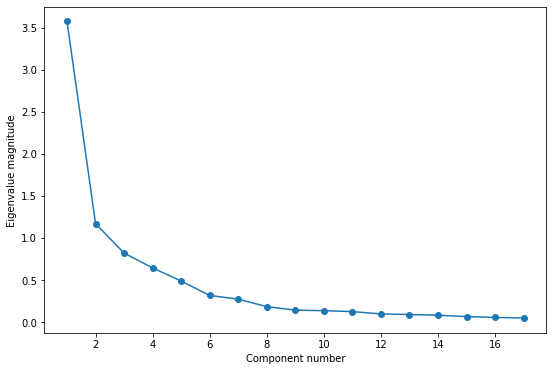

In [210]:
# Make plot
plt.figure(figsize=(9,6))
plt.plot(np.arange(1,18,1), evals_sorted[:17], marker='o', linestyle='-')
plt.xlabel('Component number')
plt.ylabel('Eigenvalue magnitude')
plt.show()

<span style="color:blue"> <i> 4. Plot the first three eigenvectors. These eigenvectors
represent the principal variations of the spectra with respect to that mean spectrum. </i></span><br>

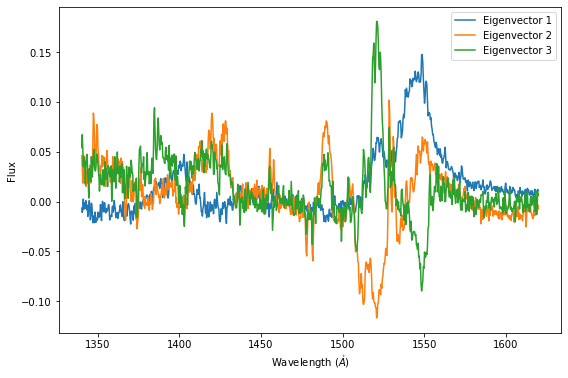

In [298]:
plt.figure(figsize=(9,6))
for i in range(3):
#     plt.plot(wavelength, 0.2*i+np.real(eigvecs[:,i]), marker='', linestyle='-', label=f'Eigenvector {i+1}')
    plt.plot(wavelength, np.real(eigvecs[:,i]), marker='', linestyle='-', label=f'Eigenvector {i+1}')
plt.xlabel('Wavelength ($\mathring{A}$)')
plt.ylabel('Flux')
plt.legend()
plt.show()

The eigenvectors indicate the direction of the principal components, so we can re-orient the data onto the new zes by multiplying the original mean-centered data by the eigenvectors. We call the re-oriented data "PC scores." (Call the PC score matrix $\bf Z$) Suppose that we have $k$ eigenvectors. Construct the matrix of eigenvectors $\bf V = [v_1 v_2 ... v_k]$, with $\bf v_i$ the $i$th highest eigenvector. Then, we can get 18 $\times\ k$ PC score matrix by multiplying the 18 $\times$ 824 data matrix with the 824 $\times\ k$ eigenvector matrix:
<br><br>
$$ \bf Z = X_c V $$
<br><br>
Then, we can reconstruct the data by mapping it back to 824 dimensions with $\bf V^T$:
<br><br>
$$ \bf \hat{X} = \boldsymbol \mu + Z V^T $$
where $\boldsymbol \mu$ is the vector of mean QSO flux.
<br><br>
Now, comparing the original data with the reconstructed data, we can calculate the residuals. Let $\bf X_{(i)}, \hat{X}_{(i)}$ denote the rows of $\bf X, \hat{X}$ respectively. Remember that the data matrix has the dimension 18 $\times$ 824, so each row $\bf X_{(i)}$ corresponding the spectra of one particular QSO. (For example, if you wish to see the QSO spectra in row 7, you can plot $\bf X_{(7)}$ as a function of wavelength.). Then, we can simply calculate the residual as $\frac{1}{N} \sum_{i=1}^N \bf |\hat{X}_{(i)} - X_{(i)}|^2$ where $N$ is the total number of QSOs (NOTE: $\bf |\hat{X}_{(i)} - X_{(i)}|$ is the magnitude of the difference between two vectors $\bf \hat{X}_{(i)}$ and $\bf X_{(i)}$.)
<br><br>
<span style="color:blue"> <i> 5. First, start with only mean flux value $\boldsymbol \mu$ (in this case $\bf \hat{X} = \boldsymbol \mu, V = 0$) and calculate the residual. Then, do the reconstruction using the first two principal eigenvectors $\bf V = [v_1 v_2]$ and calculate the residual. Finally, let $\bf V = [v_1 v_2 ... v_6]$ (the first six principal eigenvectors) and compute the residual. </i></span><br>

In [114]:
def residual(X, Xhat):
    return 1/len(X) * np.linalg.norm(Xhat - X)**2

def Vs(k):
    return eigvecs.T[:k].T

def Z(V, X_c=X_c):
    return X_c @ V

In [116]:
mu = meanflux
print('Residual V=0:', residual(X, mu))

V = Vs(2)
Xhat = mu + Z(V) @ V.T
print('Residual V=[v1 v2]:', residual(X, Xhat))

V = Vs(6)
Xhat = mu + Z(V) @ V.T
print('Residual V=[v1 v2 ... v6]:', residual(X, Xhat))

Residual V=0: 7.838200342799546
Residual V=[v1 v2]: 3.3605450864683313
Residual V=[v1 v2 ... v6]: 1.219905223712885


<span style="color:blue"> <i> 6. For any two QSO spectra, plot the original and reconstructed spectra using the first six principal eigenvectors. </i></span><br>

/Users/elizabeth/opt/miniconda3/envs/orensteinlab/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


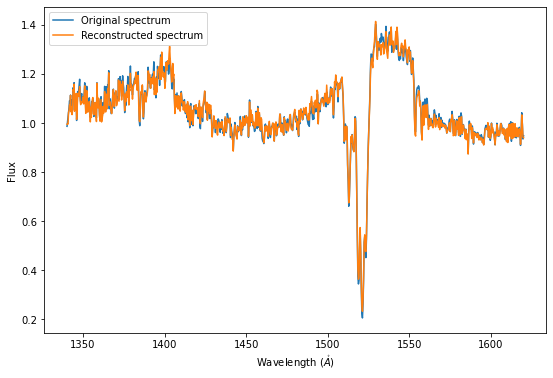

In [297]:
plt.figure(figsize=(9,6))
plt.plot(wavelength, flux[7], marker='', linestyle='-', label=f'Original spectrum')
plt.plot(wavelength, Xhat[7], marker='', linestyle='-', label=f'Reconstructed spectrum')
plt.xlabel('Wavelength ($\mathring{A}$)')
plt.ylabel('Flux')
plt.legend()
plt.show()

<span style="color:blue"> <i> 7. Plot the residual as a function of the number of included eigenvectors (1,2,3,...,17). </i></span><br>

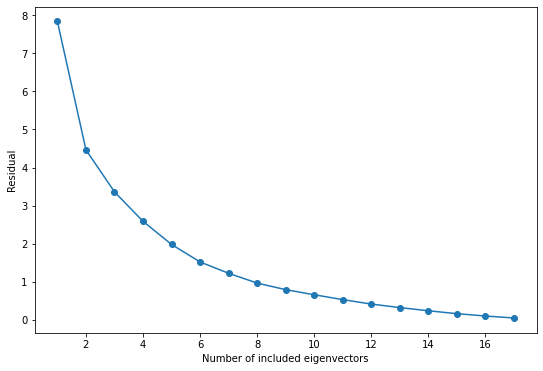

In [218]:
residuals = [residual(X, mu + Z(Vs(i)) @ Vs(i).T) for i in range(17)]

plt.figure(figsize=(9,6))
plt.plot(np.arange(1,18,1), residuals, marker='o', linestyle='-')
plt.xlabel('Number of included eigenvectors')
plt.ylabel('Residual')
# plt.legend()
plt.show()

In this problem, we only have 18 QSO spectra, so the idea of using PCA may seem silly. We can also use SVD to find eigenvalues and eigenvectors. With SVD, we get $\bf X_c = USV^T$. Then, the covariance matrix is $\bf C$ $ = \frac{1}{N-1}$ $\bf X_c^T X_c$ $ = \frac{1}{N-1}$ $\bf VS^2V^T.$ Then, the eigenvalues are the squared singular values scaled by the factor $\frac{1}{N-1}$ and the eigenvectors are the columns of $\bf V$.
<br><br>
<span style="color:blue"> <i> 8. Find the eigenvalues applying SVD to the mean-centered data matrix $\bf X_c$. </i></span><br>

Eigenvalues:  [3.57183360e+00 1.16921314e+00 8.19491399e-01 6.43886056e-01
 4.87138879e-01 3.16043520e-01 2.72246202e-01 1.83227778e-01
 1.41340818e-01 1.35417557e-01 1.24349547e-01 9.68536857e-02
 8.91735508e-02 8.05492370e-02 6.53953675e-02 5.46083371e-02
 4.85022745e-02 3.05988485e-30]


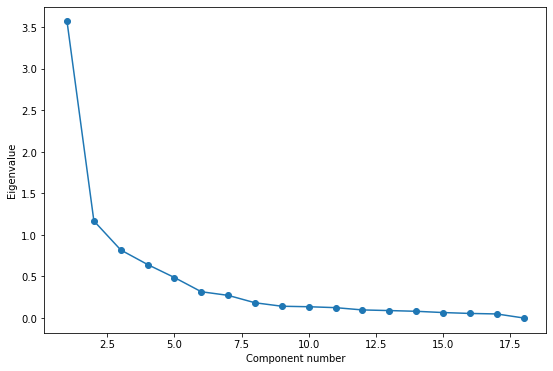

In [221]:
from scipy.linalg import svd

U, S, VT = svd(X_c)
svd_evals = 1/(len(X_c)-1) * S**2

# Print Eigenvalues
print('Eigenvalues: ', svd_evals)

plt.figure(figsize=(9,6))
plt.plot(np.arange(1,19,1), svd_evals, marker='o', linestyle='-')
plt.xlabel('Component number')
plt.ylabel('Eigenvalue')
plt.show()

***

#### Problem 3 - Back to MNIST

In Assignment 2, we used the UMAP module to reduce the MNIST dataset to 2 dimensions (from 784) for easy visualization and observed that different classes (10 digits - "0", "1", ..., "9") got separated nicely into clusters when the MNIST data are embedded into lower dimensions by UMAP.

In this exercise, instead of the UMAP module, we use the PCA method for dimensionality reduction. 

As mentioned in Problem 2, PCA is a technique for reducing the number of dimensions in a dataset whilst retaining most information. It is using the correlation between some dimensions and tries to provide a minimum number of variables that keeps the maximum amount of variation or information about how the original data is distributed. It does not do this using guesswork but using hard mathematics and it uses something known as the eigenvalues and eigenvectors of the data-matrix. These eigenvectors of the covariance matrix have the property that they point along the major directions of variation in the data. These are the directions of maximum variation in a dataset. Here, we use the scikit-learn implementation of PCA: https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html

First, load the MNIST data:

In [223]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784')
X = mnist.data
Y = mnist.target

X = X.to_numpy()
Y = Y.to_numpy()

"$X$" contains information about the given MNIST digits. We have a 28x28 pixel grid, so each image is a vector of length 784; we have 70,000 images (digits), so $X$ is a 70,000x784 matrix. "$Y$" is a label (0-9; the category to which each image belongs) vector of length 70,000.

<span style="color:blue"> <i> 1. Do the following:

(1) Randomly shuffle data (i.e. randomize the order)

  (Note: The label $Y_1$ corresponds to a vector $X_{1j}$, and even after shuffling, $Y_1$ should still correspond to $X_{1j}$.)
  
  
(2) Select 1/3 of the data. (You are free to work with a larger set of the data, but it will take much longer time to train.)


(3) Split data into training and test samples using train_test_split (https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html). Set train_size = 0.8. (80% of $X$ is our training samples.) Print the dimension of training and test samples. </i></span> <br>

In [224]:
from sklearn.model_selection import train_test_split
from sklearn.utils import check_random_state

combined_data = np.column_stack((X, Y))
np.random.shuffle(combined_data)
X_shuff = combined_data[:, :-1]  # extract data (all columns except the last one)
Y_shuff = combined_data[:, -1]  # extract labels (last column)
data_subset = combined_data[:len(Y)//3]

X_train, X_test, Y_train, Y_test = train_test_split(X_shuff[:len(Y)//3], Y_shuff[:len(Y)//3], train_size=0.8)
print(f'Dimension of training samples: X={np.shape(X_train)}, Y={np.shape(Y_train)}')
print(f'Dimension of testing samples: X={np.shape(X_test)}, Y={np.shape(Y_test)}')

Dimension of training samples: X=(18666, 784), Y=(18666,)
Dimension of testing samples: X=(4667, 784), Y=(4667,)


Many machine learning algorithms are also not scale invariant, and hence we need to scale the data (different features to a uniform scale). All this comes under preprocessing the data. (http://scikit-learn.org/stable/modules/preprocessing.html#preprocessing) PCA is a prime example of when such normalization is important; if the variables are not measured on the same scale, then each principal component can be dominated by a single variable. 

In this exercise, the MNIST pixel values in images should also be scaled prior to providing the images as an input to PCA. There are three main types of pixel scaling techniques: normalization (scaling pixel to the range 0-1), centering (scale pixel values to have a zero-mean), and standardization (scale pixel values to have a zero-mean and unit-variance). 

First, let us try normalization. Each pixel contains a greyscale value quantified by an integer between 0 and 255. To standardize the dataset, we normalize the "$X$" data in the interval [0, 1].

<span style="color:blue"> <i> 2. Normalize the X data (both training and test).

In [225]:
X_train_norm = X_train/255
X_test_norm = X_test/255

Next, using scikit-learn's PCA module, we can select the first two principal components from the original 784 dimensions.

In [226]:
from sklearn.decomposition import PCA

(1) Define the PCA model with the first 2 principal components: 

&nbsp; **pca = PCA(n_components=2)**

(2) Using "fit_transform," fit the model with the training X data and apply the dimensionality reduction on it.

&nbsp; **X_train_PCA = pca.fit_transform(training X data)**

(3) With the same model, apply the dimensionality reduction on the test X data.

&nbsp; **X_test_PCA = pca.transform(test X data)**

<span style="color:blue"> <i> 3. This problem is similar to HW2-Q4-Part3. For both training and test samples, create a scatterplot of the first and second principal component and color each of the different types of digits with a different color. Label each axis (e.g. x-axis: 1st principal component, y-axis: 2nd principal component). How does it compare to the UMAP results?

In [227]:
pca = PCA(n_components=2)
X_train_PCA = pca.fit_transform(X_train_norm)
X_test_PCA = pca.transform(X_test_norm)

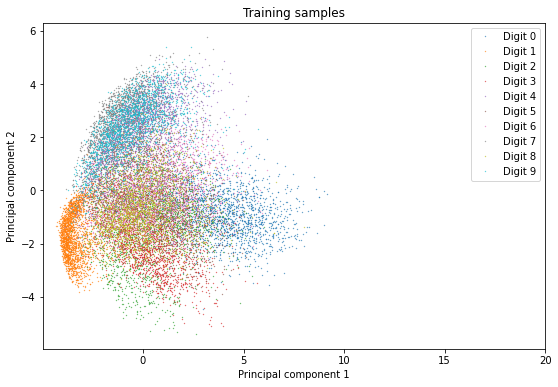

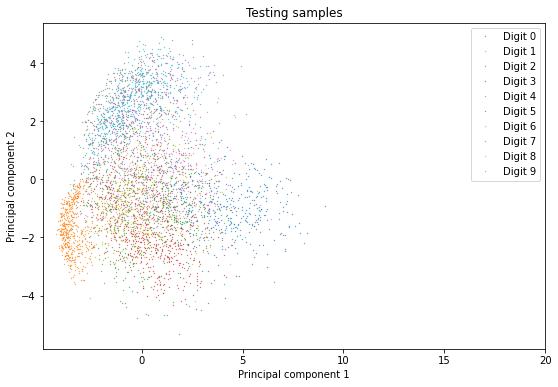

In [230]:
plt.figure(figsize=(9,6))
for i in range(10):
    plt.plot(X_train_PCA[:,0][Y_train==f'{i}'], X_train_PCA[:,1][Y_train==f'{i}'], marker='o', linestyle='', ms=0.3, label=f'Digit {i}')
plt.xlim(right=20)
plt.legend()
plt.xlabel('Principal component 1')
plt.ylabel('Principal component 2')
plt.title('Training samples')
plt.show()

plt.figure(figsize=(9,6))
for i in range(10):
    plt.plot(X_test_PCA[:,0][Y_test==f'{i}'], X_test_PCA[:,1][Y_test==f'{i}'], marker='o', linestyle='', ms=0.3, label=f'Digit {i}')
plt.xlim(right=20)
plt.legend()
plt.xlabel('Principal component 1')
plt.ylabel('Principal component 2')
plt.title('Testing samples')
plt.show()

<span style="color:blue"> <i> 4. Select the first three principal components and make 3D scatterplot on the training data. (similar to HW2-Q4-Part5)

In [232]:
from mpl_toolkits.mplot3d import Axes3D

In [233]:
pca = PCA(n_components=3)
X_train_PCA = pca.fit_transform(X_train_norm)
X_test_PCA = pca.transform(X_test_norm)

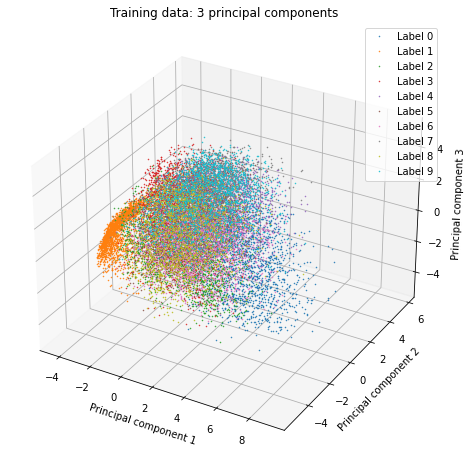

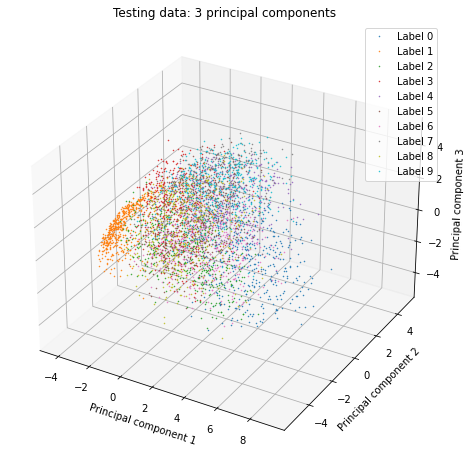

In [236]:
x_3c, y_3c, z_3c = X_train_PCA[:,0], X_train_PCA[:,1], X_train_PCA[:,2]

fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(projection='3d')
for i in range(10):
    ax.plot(x_3c[Y_train==f'{i}'], y_3c[Y_train==f'{i}'], z_3c[Y_train==f'{i}'], marker='o', linestyle='', ms=0.5, label=f'Label {i}')
ax.legend()
ax.set_xlabel('Principal component 1')
ax.set_ylabel('Principal component 2')
ax.set_zlabel('Principal component 3')
plt.title('Training data: 3 principal components')
plt.show()

x_3c, y_3c, z_3c = X_test_PCA[:,0], X_test_PCA[:,1], X_test_PCA[:,2]

fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(projection='3d')
for i in range(10):
    ax.plot(x_3c[Y_test==f'{i}'], y_3c[Y_test==f'{i}'], z_3c[Y_test==f'{i}'], marker='o', linestyle='', ms=0.5, label=f'Label {i}')
ax.legend()
ax.set_xlabel('Principal component 1')
ax.set_ylabel('Principal component 2')
ax.set_zlabel('Principal component 3')
plt.title('Testing data: 3 principal components')
plt.show()

In [ ]:
plt.figure(figsize=(9,6))
for i in range(10):
    plt.plot(X_train_PCA[:,0][Y_train==f'{i}'], X_train_PCA[:,1][Y_train==f'{i}'], marker='o', linestyle='', ms=0.3, label=f'Digit {i}')
plt.xlim(right=20)
plt.legend()
plt.xlabel('Principal component 1')
plt.ylabel('Principal component 2')
plt.title('Training samples')
plt.show()

plt.figure(figsize=(9,6))
for i in range(10):
    plt.plot(X_test_PCA[:,0][Y_test==f'{i}'], X_test_PCA[:,1][Y_test==f'{i}'], marker='o', linestyle='', ms=0.3, label=f'Digit {i}')
plt.xlim(right=20)
plt.legend()
plt.xlabel('Principal component 1')
plt.ylabel('Principal component 2')
plt.title('Testing samples')
plt.show()

From the graph we can see the two or three components definitely hold some information, especially for specific digits, but clearly not enough to set all of them apart. There are other techniques, such as UMAP module or t-SNE (t-Distributed Stochastic Neighbouring Entities), which can better reduce the dimensions for visualisation.

***

In [237]:
from sklearn.neighbors import KNeighborsClassifier as knn

Now, we will introduce K-nearest neighbors (KNN), one of the most widely used machine learning classification techniques. We use scikit-learn implementation of KNN: https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html

Ideally, we should tune KNN hyperparameters by doing a grid search using k-fold cross validation, but in this exercise we simply use default parameters with n_neighbors = 6. 

(1) Define the knn classifier

&nbsp; **clf = knn(n_neighbors=6)**

(2) Fit the model

&nbsp; **clf.fit(training X data, training Y/target data)**

(3) Get the classification accuracy on the test data

&nbsp; **clf.score(test X data, test Y/target data)**

<span style="color:blue"> <i> 5. Evaluate the classification accuracy on the test data using a KNN classifier.

In [238]:
clf = knn(n_neighbors=6)
clf.fit(X_train_norm, Y_train)
clf.score(X_test_norm, Y_test)

0.9547889436468824

The above KNN classifier considers all 784 features for each image when making its decisions. What if you do not need that many? It is possible that a lot of those features do not really affect our predictions that much. Or worse, KNN could be considering feature anomalies that are unique to our training data, resulting in overfitting. One way to deal with this is by removing features that aren’t contributing much. 

Now, suppose you take the first two principal components from PCA and fit your model using those two components. 

&nbsp; **pca = PCA(n_components=2)**

&nbsp; **X_train_PCA = pca.fit_transform(training X data)**

&nbsp; **X_test_PCA = pca.transform(test X data)**

Now you can take X_train_PCA, along with training Y data, to fit the KNN model and evaluate the classification accuracy.

<span style="color:blue"> <i> 6. Evaluate the classification accuracy with different number of PCA componenets. Let N_PCA_component = [2, 10, 20, 30, 40, 50, 60, 100, 200, 300, 400, 700]. Plot classification accuracy vs. number of PCA components. How does it compare to the accuracy in Part 5? Draw a horizontal line for the accuracy with all 784 features.

In [254]:
N_PCA_component = [2, 10, 20, 30, 40, 50, 60, 100, 200, 300, 400, 700]
accuracy = np.zeros(len(N_PCA_component))

for i, n in enumerate(N_PCA_component):
    pca = PCA(n_components=n)
    X_train_PCA = pca.fit_transform(X_train_norm)
    X_test_PCA = pca.transform(X_test_norm)
    clf = knn(n_neighbors=6)
    clf.fit(X_train_PCA, Y_train)
    accuracy[i] = clf.score(X_test_PCA, Y_test)

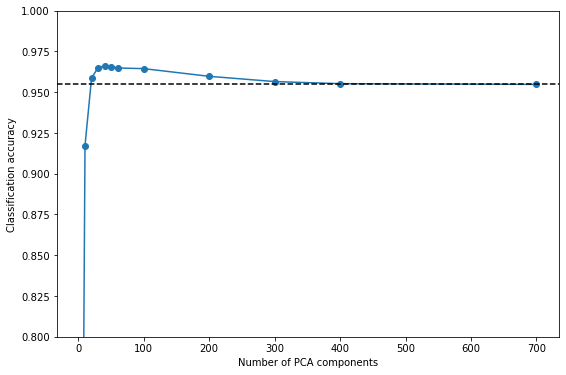

In [302]:
accuracy784 = 0.9547889436468824
plt.figure(figsize=(9,6))
plt.plot(N_PCA_component, accuracy, marker='o')
plt.axhline(accuracy784, linestyle='--', color='k')
plt.xlabel('Number of PCA components')
plt.ylabel('Classification accuracy')
plt.ylim(0.8,1)
plt.show()

Somehow the accuracy is higher for some smaller numbers of PCA components, but it approaches the same value as that in part 5 (considering all 784 features).

<span style="color:blue"> <i> 7. Instead of the PCA method, fit the UMAP model with the training data and do unsupervised learning. Reduce data to 2 dimensions (embed to 2 dimensions) and train the KNN model on the embedded training data. Compared to Part 6, does it give you a higher classification accuracy even with n_component = 2?

In [261]:
# !pip install umap-learn
import umap

In [265]:
model = umap.UMAP()
embedding_train = model.fit_transform(X_train_norm)
embedding_test = model.transform(X_test_norm)

clf = knn(n_neighbors=6)
clf.fit(embedding_train, Y_train)
clf.score(embedding_test, Y_test)

0.9370044996785943

It gives a slightly lower classification accuracy than fitting the model using >=20 PCA components and a higher accuracy than fitting the model with <20 PCA components. When the data are embedded in 2 dimensions, the UMAP model significantly outperforms the PCA model in terms of classification accuracy.

***

Instead of pixel normalization, we can also try feature rescaling through standardization (rescaling the features such that they have the properties of a standard normal distribution with a mean of zero and a standard deviation of one). We can use sklearn.preprocessing.StandardScaler for this job.


In [266]:
from sklearn.preprocessing import StandardScaler

(1) Define the StandardScaler

&nbsp; **sc = StandardScaler()**

(2) Fit the training X data and then transform it.

&nbsp; **X_train = sc.fit_transform(training X data)**

(3) Perform standardization on the test X data.

&nbsp; **X_test = sc.transform(test X data)**

<span style="color:blue"> <i> 8. Re-load the MNIST data (Repeat Part 1) and try standardization on both training and test X data following the above steps. Evaluate the classification accuracy using a KNN classifier. How does it compare to Part 5?

In [267]:
sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)

In [268]:
clf = knn(n_neighbors=6)
clf.fit(X_train_sc, Y_train)
clf.score(X_test_sc, Y_test)

0.9237197343046926

It's lower than in part 5.

<span style="color:blue"> <i> 9. Again, take the data from Part 8 (standardized X data) and do unsupervised learning using the UMAP module. Reduce the data to 2 dimensions, and plot the embedding as a scatterplot (for the training data) and color by the target array. How does it compare to HW2-Q5f? Which pixel rescaling method do you think works better? 

In [269]:
model = umap.UMAP()
embedding_train_sc = model.fit_transform(X_train_sc)
embedding_test_sc = model.transform(X_test_sc)

clf = knn(n_neighbors=6)
clf.fit(embedding_train_sc, Y_train)
clf.score(embedding_test_sc, Y_test)

0.870580672809085

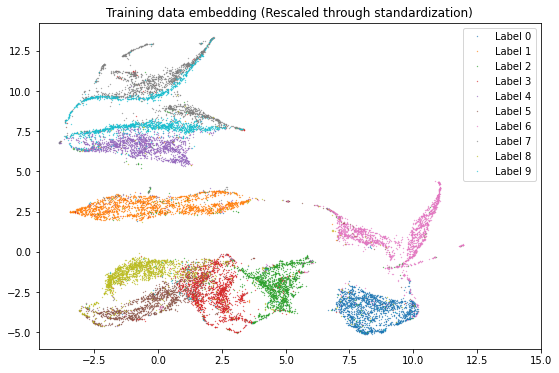

In [272]:
plt.figure(figsize=(9,6))
for i in range(10):
    plt.plot(embedding_train_sc[:,0][Y_train==f'{i}'], embedding_train_sc[:,1][Y_train==f'{i}'], marker='o', linestyle='', ms=0.3, label=f'Label {i}')
plt.xlim(right=15)
plt.legend()
plt.title('Training data embedding (Rescaled through standardization)')
plt.show()

This appears worse than HW2-Q5f. In some cases, the data corresponding to different labels are found in clusters which are not sufficiently separated, touch or overlap (e.g. digits 4, 7, 9), and in others, data that have the same label have been split into different clusters (e.g. digits 7 and 9). While sume clusters overlap in HW2-Q5f, the distance between the clusters is larger (for the most part) and data with the same label have not been incorrectly split into different clusters. In some cases, this implementation (unsupervised learning on data that have been rescaled through standardization and embedded in 2 dimensions) has created too many clusters for a given label, and in other cases, it has not discriminated between data of different labels well enough.

Rescaling through standardization performed worse than normalizing for pixel rescaling (accuracy of ~0.87058 for standardization on 2D embedding vs. ~0.93700 for normalization on 2D embedding, compared to ~0.95479 for normalization on all 784 features).

***